In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np

# For inline plots
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [31]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 3  # increase later if you want better accuracy

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,255] -> [0,1]
])

# Datasets
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)


(60000, 10000)

In [32]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B,32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B,32,14,14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B,64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B,64,7,7)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model


SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

# Save model
torch.save(model.state_dict(), "mnist_cnn.pth")
print("Model saved to mnist_cnn.pth")


Epoch [1/3] Train Loss: 0.1764 | Train Acc: 94.64% | Test Loss: 0.0554 | Test Acc: 98.17%
Epoch [2/3] Train Loss: 0.0486 | Train Acc: 98.44% | Test Loss: 0.0347 | Test Acc: 98.82%
Epoch [3/3] Train Loss: 0.0345 | Train Acc: 98.93% | Test Loss: 0.0446 | Test Acc: 98.45%
Model saved to mnist_cnn.pth


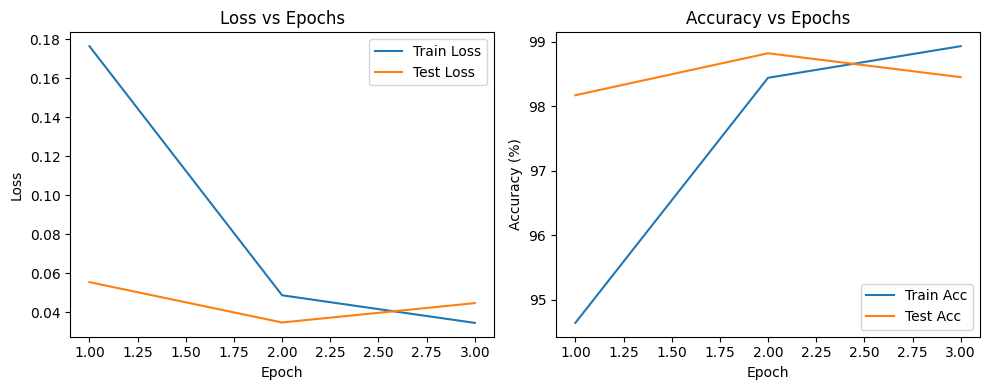

In [35]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [a*100 for a in train_accuracies], label="Train Acc")
plt.plot(epochs, [a*100 for a in test_accuracies], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def fgsm_attack(model, images, labels, epsilon, criterion):
    model.eval()

    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Sign of gradient
    grad_sign = images.grad.data.sign()

    # Perturb the images
    adv_images = images + epsilon * grad_sign

    # pixel values in [0,1]
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images


In [ ]:
def evaluate_adversarial(model, loader, epsilon, criterion):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon, criterion)
        outputs = model(adv_images)
        _, predicted = outputs.max(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return correct / total


# Evaluate on test data first
clean_test_loss, clean_test_acc = evaluate(model, test_loader, criterion)
print(f"Clean Test Accuracy: {clean_test_acc*100:.2f}%")

epsilons = [0.0, 0.05, 0.1, 0.2, 0.3]
adv_accuracies = []

for eps in epsilons:
    adv_acc = evaluate_adversarial(model, test_loader, eps, criterion)
    adv_accuracies.append(adv_acc)
    print(f"Epsilon: {eps:.2f} | Adversarial Test Accuracy: {adv_acc*100:.2f}%")


Clean Test Accuracy: 98.45%
Epsilon: 0.00 | Adversarial Test Accuracy: 98.45%
Epsilon: 0.05 | Adversarial Test Accuracy: 94.35%
Epsilon: 0.10 | Adversarial Test Accuracy: 84.99%
Epsilon: 0.20 | Adversarial Test Accuracy: 43.82%
Epsilon: 0.30 | Adversarial Test Accuracy: 8.62%


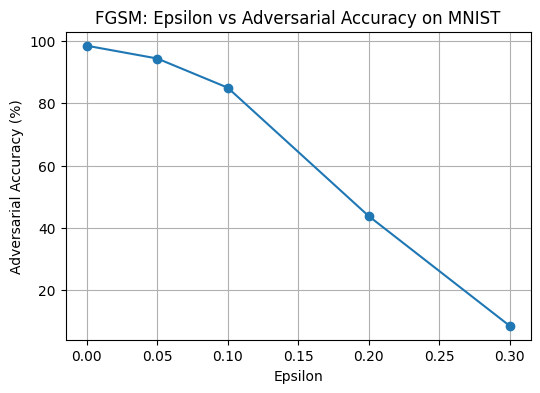

In [38]:
plt.figure(figsize=(6,4))
plt.plot(epsilons, [a*100 for a in adv_accuracies], marker="o")
plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy (%)")
plt.title("FGSM: Epsilon vs Adversarial Accuracy on MNIST")
plt.grid(True)
plt.show()


In [40]:
# Make a copy of the clean-trained model for adversarial training
adv_model = SimpleCNN().to(device)
adv_model.load_state_dict(model.state_dict())  # start from clean model weights

adv_optimizer = optim.Adam(adv_model.parameters(), lr=learning_rate)
adv_criterion = nn.CrossEntropyLoss()

adv_model


SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
def train_one_epoch_adversarial(model, loader, optimizer, criterion, epsilon):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)


        # Use the same FGSM function as before
        adv_images = fgsm_attack(model, images, labels, epsilon, criterion)

    
        optimizer.zero_grad()

        outputs_clean = model(images)
        outputs_adv   = model(adv_images)

        loss_clean = criterion(outputs_clean, labels)
        loss_adv   = criterion(outputs_adv, labels)

        # Mixed loss: 0.5 * clean + 0.5 * adversarial
        loss = 0.5 * loss_clean + 0.5 * loss_adv

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        # Track accuracy on adversarial images
        _, predicted = outputs_adv.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    adv_train_acc = correct / total
    return avg_loss, adv_train_acc


In [ ]:
epsilon_train = 0.2          # strength of adversarial perturbation during training
num_adv_epochs = 3           # can increase later

adv_train_losses = []
adv_train_accuracies = []
adv_test_clean_accuracies = []
adv_test_adv_accuracies = []

print(f"Starting adversarial training with epsilon_train = {epsilon_train}")

for epoch in range(1, num_adv_epochs + 1):
    adv_train_loss, adv_train_acc = train_one_epoch_adversarial(
        adv_model, train_loader, adv_optimizer, adv_criterion, epsilon_train
    )

    # Evaluate adversarially-trained model on clean test data
    clean_loss, clean_acc = evaluate(adv_model, test_loader, adv_criterion)

    # Evaluate robustness at the same epsilon used in training
    adv_acc = evaluate_adversarial(adv_model, test_loader, epsilon_train, adv_criterion)

    adv_train_losses.append(adv_train_loss)
    adv_train_accuracies.append(adv_train_acc)
    adv_test_clean_accuracies.append(clean_acc)
    adv_test_adv_accuracies.append(adv_acc)

    print(f"[Adv Epoch {epoch}/{num_adv_epochs}] "
          f"Train Loss: {adv_train_loss:.4f} | "
          f"Train Adv Acc: {adv_train_acc*100:.2f}% | "
          f"Test Clean Acc: {clean_acc*100:.2f}% | "
          f"Test Adv Acc (eps={epsilon_train}): {adv_acc*100:.2f}%")

# Save adversarially trained model
torch.save(adv_model.state_dict(), "mnist_cnn_adv_trained.pth")
print("Adversarially trained model saved to mnist_cnn_adv_trained.pth")


Starting adversarial training with epsilon_train = 0.2
[Adv Epoch 1/3] Train Loss: 0.1943 | Train Adv Acc: 88.17% | Test Clean Acc: 98.54% | Test Adv Acc (eps=0.2): 94.80%
[Adv Epoch 2/3] Train Loss: 0.0610 | Train Adv Acc: 97.06% | Test Clean Acc: 99.08% | Test Adv Acc (eps=0.2): 95.30%
[Adv Epoch 3/3] Train Loss: 0.0932 | Train Adv Acc: 94.66% | Test Clean Acc: 99.08% | Test Adv Acc (eps=0.2): 96.15%
Adversarially trained model saved to mnist_cnn_adv_trained.pth


In [43]:
epsilons_eval = [0.0, 0.05, 0.1, 0.2, 0.3]

clean_model_accs = []
adv_trained_accs = []

print("Evaluating original model vs adversarially trained model")

for eps in epsilons_eval:
    acc_clean_model = evaluate_adversarial(model, test_loader, eps, criterion)
    acc_adv_model   = evaluate_adversarial(adv_model, test_loader, eps, adv_criterion)

    clean_model_accs.append(acc_clean_model)
    adv_trained_accs.append(acc_adv_model)

    print(f"Epsilon: {eps:.2f} | "
          f"Clean-trained model: {acc_clean_model*100:.2f}% | "
          f"Adv-trained model: {acc_adv_model*100:.2f}%")


Evaluating original model vs adversarially trained model
Epsilon: 0.00 | Clean-trained model: 98.45% | Adv-trained model: 99.08%
Epsilon: 0.05 | Clean-trained model: 94.35% | Adv-trained model: 96.66%
Epsilon: 0.10 | Clean-trained model: 84.99% | Adv-trained model: 94.20%
Epsilon: 0.20 | Clean-trained model: 43.82% | Adv-trained model: 96.15%
Epsilon: 0.30 | Clean-trained model: 8.62% | Adv-trained model: 84.55%


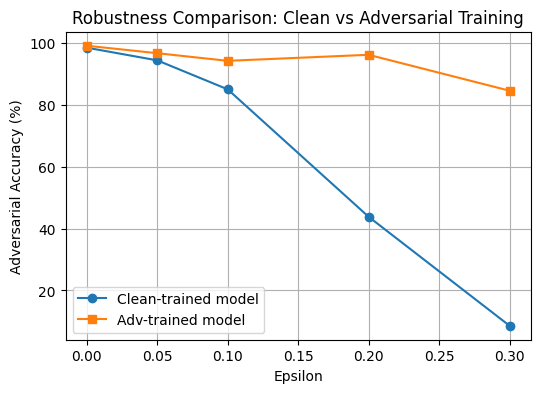

In [44]:
plt.figure(figsize=(6,4))
plt.plot(epsilons_eval, [a*100 for a in clean_model_accs], marker="o", label="Clean-trained model")
plt.plot(epsilons_eval, [a*100 for a in adv_trained_accs], marker="s", label="Adv-trained model")

plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy (%)")
plt.title("Robustness Comparison: Clean vs Adversarial Training")
plt.legend()
plt.grid(True)
plt.show()


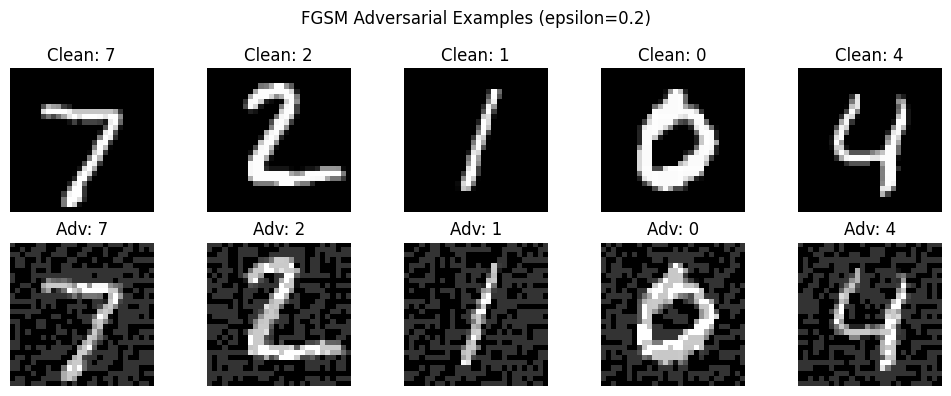

In [45]:
# Visualize how adv_model behaves on adversarial examples
visualize_adversarial_examples(
    adv_model,
    test_loader,
    epsilon=epsilon_train,   # same epsilon as used in adversarial training
    criterion=adv_criterion,
    num_examples=5
)
